# Multi-Panel SkewT's
## We will be creating a multi-panel SkewT for different sites within our XWRF Model data

### Import the libraries we need

In [1]:
import xwrf
import xarray as xr
import pint_xarray
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import metpy.calc as mpcalc
from metpy.plots import Hodograph, SkewT
from metpy.units import units, pandas_dataframe_to_unit_arrays
from datetime import datetime, timedelta
import pandas as pd
from pyproj import Transformer, CRS

First we will read in our dataset from xwrf, and we will remove Dobson units. Next we use methods from the datetime library to determine the time of our event, and then use it to select the most recent the date and time that we'll use for our selected Skew-T

In [2]:
ds=xr.open_dataset('/ktyle_rit/mp856533/atm498/icestorm/exp1/wrfout_d01_2008-12-11_00:00:00', chunks='auto').xwrf.postprocess()
ds = ds.drop_vars('O3_GFS_DU') # Avoids MetPy units-parsing error with Dobson units
ds

<xarray.Dataset> Size: 645MB
Dimensions:                    (Time: 49, y: 49, x: 49, soil_layers_stag: 4,
                                z: 56, x_stag: 50, y_stag: 50, z_stag: 57,
                                num_stoch_levels: 57, seed_dim_stag: 2)
Coordinates: (12/15)
    XLAT                       (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    XLONG                      (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    XTIME                      (Time) datetime64[ns] 392B dask.array<chunksize=(49,), meta=np.ndarray>
    XLAT_U                     (y, x_stag) float32 10kB dask.array<chunksize=(49, 50), meta=np.ndarray>
    XLONG_U                    (y, x_stag) float32 10kB dask.array<chunksize=(49, 50), meta=np.ndarray>
    XLAT_V                     (y_stag, x) float32 10kB dask.array<chunksize=(50, 49), meta=np.ndarray>
    ...                         ...
  * z_stag                     (z_stag) float32 228B 1.0 0.9938 ... 0.003327 0.0
  * Time                       (Time) datetime64[ns] 392B 2008-12-11 ... 2008...
  * y_stag                     (y_stag) float64 400B -8.82e+05 ... 8.82e+05
  * x                          (x) float64 392B -8.64e+05 -8.28e+05 ... 8.64e+05
  * x_stag                     (x_stag) float64 400B -8.82e+05 ... 8.82e+05
  * y                          (y) float64 392B -8.64e+05 -8.28e+05 ... 8.64e+05
Dimensions without coordinates: soil_layers_stag, num_stoch_levels,
                                seed_dim_stag
Data variables: (12/195)
    Times                      (Time) |S19 931B dask.array<chunksize=(49,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    ZS                         (Time, soil_layers_stag) float32 784B dask.array<chunksize=(49, 4), meta=np.ndarray>
    DZS                        (Time, soil_layers_stag) float32 784B dask.array<chunksize=(49, 4), meta=np.ndarray>
    VAR_SSO                    (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    BATHYMETRY_FLAG            (Time) int32 196B dask.array<chunksize=(49,), meta=np.ndarray>
    ...                         ...
    geopotential_height        (Time, z_stag, y, x) float32 27MB dask.array<chunksize=(5, 57, 49, 49), meta=np.ndarray>
    wind_east                  (Time, z, y, x) float32 26MB dask.array<chunksize=(5, 56, 49, 49), meta=np.ndarray>
    wind_north                 (Time, z, y, x) float32 26MB dask.array<chunksize=(5, 56, 49, 49), meta=np.ndarray>
    wind_east_10               (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    wind_north_10              (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    wrf_projection             object 8B +proj=lcc +x_0=0 +y_0=0 +a=6370000 +...
Attributes: (12/141)
    TITLE:                            OUTPUT FROM WRF V4.5.1 MODEL
    START_DATE:                      2008-12-11_00:00:00
    SIMULATION_START_DATE:           2008-12-11_00:00:00
    WEST-EAST_GRID_DIMENSION:        50
    SOUTH-NORTH_GRID_DIMENSION:      50
    BOTTOM-TOP_GRID_DIMENSION:       57
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

Creating an array of times for all 48 hours of time within our dataset

In [3]:
times=np.array(ds.Time, dtype='datetime64')
times=times.astype('datetime64[s]').tolist()
starttime=times[0]
endtime=times[48]
print(f'Our starting date and time will be {starttime}')
print(f'Our ending date and time will be {endtime}')

Our starting date and time will be 2008-12-11 00:00:00
Our ending date and time will be 2008-12-13 00:00:00


Defining our Latitudes and Longitudes 

In [4]:
def sample_wrf_ds_at_latlon(ds, lat, long):
    trf = Transformer.from_crs(CRS.from_epsg(4326), ds.wrf_projection.item(), always_xy=True)
    x, y = trf.transform(long, lat)
    return ds.interp(x=x, y=y, x_stag=x, y_stag=y)

### We must import our latitudes and longitudes that we wish to use for our Skew-T's

In [5]:
ds1= sample_wrf_ds_at_latlon(ds, 42.7508, -73.5555) #KALB
ds2 = sample_wrf_ds_at_latlon(ds, 41.9389, -72.6860) #KBDL
ds3 = sample_wrf_ds_at_latlon(ds, 40.6446, -73.7797) #KJFK
ds4 = sample_wrf_ds_at_latlon(ds, 44.6542, -73.4621) #KPBG

Calculating all the variables that we need from each dataset, variables such as Dewpoint Temperature, Air Temperature, and Air Pressure

In [6]:
ds1 = ds1.metpy.quantify()
ds1['dew_point_temperature'] = mpcalc.dewpoint(
    mpcalc.vapor_pressure(ds1.air_pressure, ds1.QVAPOR)
).pint.to("degC")
ds1['air_temperature'] = mpcalc.temperature_from_potential_temperature(
    ds1.air_pressure, ds1.air_potential_temperature
).pint.to("degC")
ds1['air_pressure']=ds1.air_pressure.pint.to('hPa')

ds2 = ds2.metpy.quantify()
ds2['dew_point_temperature'] = mpcalc.dewpoint(
    mpcalc.vapor_pressure(ds2.air_pressure, ds2.QVAPOR)
).pint.to("degC")
ds2['air_temperature'] = mpcalc.temperature_from_potential_temperature(
    ds2.air_pressure, ds2.air_potential_temperature
).pint.to("degC")
ds2['air_pressure']=ds2.air_pressure.pint.to('hPa')

ds3 = ds3.metpy.quantify()
ds3['dew_point_temperature'] = mpcalc.dewpoint(
    mpcalc.vapor_pressure(ds3.air_pressure, ds3.QVAPOR)
).pint.to("degC")
ds3['air_temperature'] = mpcalc.temperature_from_potential_temperature(
    ds3.air_pressure, ds3.air_potential_temperature
).pint.to("degC")
ds3['air_pressure']=ds3.air_pressure.pint.to('hPa')

ds4 = ds4.metpy.quantify()
ds4['dew_point_temperature'] = mpcalc.dewpoint(
    mpcalc.vapor_pressure(ds4.air_pressure, ds4.QVAPOR)
).pint.to("degC")
ds4['air_temperature'] = mpcalc.temperature_from_potential_temperature(
    ds4.air_pressure, ds4.air_potential_temperature
).pint.to("degC")
ds4['air_pressure']=ds4.air_pressure.pint.to('hPa')

Plotting our Multi-Panel SkewT diagrams

In [7]:
ds.Time

<xarray.DataArray 'Time' (Time: 49)> Size: 392B
array(['2008-12-11T00:00:00.000000000', '2008-12-11T01:00:00.000000000',
       '2008-12-11T02:00:00.000000000', '2008-12-11T03:00:00.000000000',
       '2008-12-11T04:00:00.000000000', '2008-12-11T05:00:00.000000000',
       '2008-12-11T06:00:00.000000000', '2008-12-11T07:00:00.000000000',
       '2008-12-11T08:00:00.000000000', '2008-12-11T09:00:00.000000000',
       '2008-12-11T10:00:00.000000000', '2008-12-11T11:00:00.000000000',
       '2008-12-11T12:00:00.000000000', '2008-12-11T13:00:00.000000000',
       '2008-12-11T14:00:00.000000000', '2008-12-11T15:00:00.000000000',
       '2008-12-11T16:00:00.000000000', '2008-12-11T17:00:00.000000000',
       '2008-12-11T18:00:00.000000000', '2008-12-11T19:00:00.000000000',
       '2008-12-11T20:00:00.000000000', '2008-12-11T21:00:00.000000000',
       '2008-12-11T22:00:00.000000000', '2008-12-11T23:00:00.000000000',
       '2008-12-12T00:00:00.000000000', '2008-12-12T01:00:00.000000000',
       '2008-12-12T02:00:00.000000000', '2008-12-12T03:00:00.000000000',
       '2008-12-12T04:00:00.000000000', '2008-12-12T05:00:00.000000000',
       '2008-12-12T06:00:00.000000000', '2008-12-12T07:00:00.000000000',
       '2008-12-12T08:00:00.000000000', '2008-12-12T09:00:00.000000000',
       '2008-12-12T10:00:00.000000000', '2008-12-12T11:00:00.000000000',
       '2008-12-12T12:00:00.000000000', '2008-12-12T13:00:00.000000000',
       '2008-12-12T14:00:00.000000000', '2008-12-12T15:00:00.000000000',
       '2008-12-12T16:00:00.000000000', '2008-12-12T17:00:00.000000000',
       '2008-12-12T18:00:00.000000000', '2008-12-12T19:00:00.000000000',
       '2008-12-12T20:00:00.000000000', '2008-12-12T21:00:00.000000000',
       '2008-12-12T22:00:00.000000000', '2008-12-12T23:00:00.000000000',
       '2008-12-13T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    XTIME    (Time) datetime64[ns] 392B dask.array<chunksize=(49,), meta=np.ndarray>
  * Time     (Time) datetime64[ns] 392B 2008-12-11 ... 2008-12-13
Attributes:
    long_name:      Time
    standard_name:  time

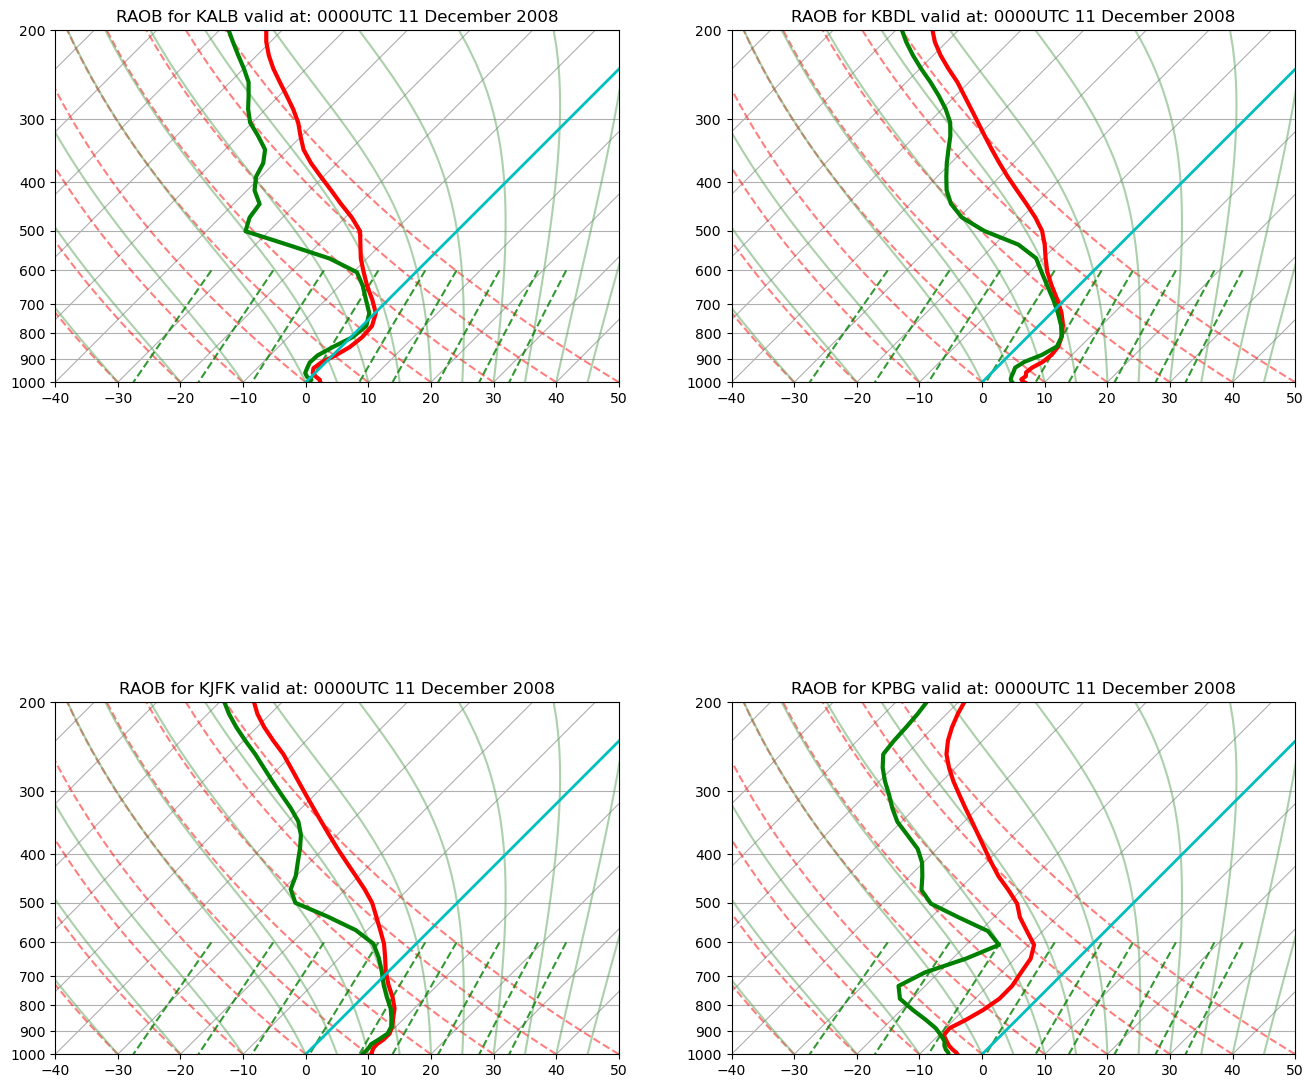

In [8]:
n=1
for h in range (0,n):
    fig = plt.figure(figsize=(16,16));
    spec = gs.GridSpec(2, 2, figure=fig);
# Dataset #1
    skew = SkewT(fig,subplot=spec[0,0], rotation=45)
    ds1=ds1.isel(Time=h)
    # Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(ds1.air_pressure.values, ds1.air_temperature.values, 'r', linewidth=3)
    skew.plot(ds1.air_pressure, ds1.dew_point_temperature, 'g', linewidth=3)
    skew.ax.barbs(ds1.air_pressure.values, ds1.wind_east.values, ds1.wind_north.values, length=6, linewidth=0.6)
    skew.ax.set_ylim(1000, 200)
    skew.ax.set_xlim(-40, 50)

# Plot a zero degree isotherm
    skew.ax.axvline(0, color='c', linestyle='-', linewidth=2)

# Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats(colors='#58a358', linestyle='-')
    skew.plot_mixing_lines();
    plt.title(f"RAOB for KALB valid at: 0000UTC 11 December 2008");

# Dataset #2 
    skew = SkewT(fig,subplot=spec[0,1], rotation=45)
    ds2=ds2.isel(Time=h)
    # Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(ds2.air_pressure.values, ds2.air_temperature.values, 'r', linewidth=3)
    skew.plot(ds2.air_pressure, ds2.dew_point_temperature, 'g', linewidth=3)
    skew.ax.set_ylim(1000, 200)
    skew.ax.set_xlim(-40, 50)

# Plot a zero degree isotherm
    skew.ax.axvline(0, color='c', linestyle='-', linewidth=2)

# Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats(colors='#58a358', linestyle='-')
    skew.plot_mixing_lines();
    plt.title(f"RAOB for KBDL valid at: 0000UTC 11 December 2008");
    
# Dataset #3
    skew = SkewT(fig,subplot=spec[1,0], rotation=45)
    ds3=ds3.isel(Time=h)
    # Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(ds3.air_pressure.values, ds3.air_temperature.values, 'r', linewidth=3)
    skew.plot(ds3.air_pressure, ds3.dew_point_temperature, 'g', linewidth=3)
    skew.ax.set_ylim(1000,200)
    skew.ax.set_xlim(-40, 50)

# Plot a zero degree isotherm
    skew.ax.axvline(0, color='c', linestyle='-', linewidth=2)

# Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats(colors='#58a358', linestyle='-')
    skew.plot_mixing_lines();
    plt.title(f"RAOB for KJFK valid at: 0000UTC 11 December 2008");
    
# Dataset #4
    skew = SkewT(fig,subplot=spec[1,1], rotation=45)
    ds4=ds4.isel(Time=h)
    # Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(ds4.air_pressure.values, ds4.air_temperature.values, 'r', linewidth=3)
    skew.plot(ds4.air_pressure, ds4.dew_point_temperature, 'g', linewidth=3)
    skew.ax.set_ylim(1000,200)
    skew.ax.set_xlim(-40, 50)

# Plot a zero degree isotherm
    skew.ax.axvline(0, color='c', linestyle='-', linewidth=2)

# Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats(colors='#58a358', linestyle='-')
    skew.plot_mixing_lines();
    plt.title(f"RAOB for KPBG valid at: 0000 UTC 11 December 2008");



In [ ]:
n=1
for h in range (0,n):
    fig = plt.figure(figsize=(16,16));
    spec = gs.GridSpec(2, 2, figure=fig);
    for i in range (0,2):
      for j in range (0, 2):
        for k in DS:
            skew = SkewT(fig,subplot=spec[i,j], rotation=45)
    
    
#    skew = SkewT(subplot=spec[i], rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
            skew.plot(k.air_pressure.values, k.air_temperature.values, 'r', linewidth=3)
            skew.plot(k.air_pressure, k.dew_point_temperature, 'g', linewidth=3)
            skew.ax.set_ylim(1000, 0)
            skew.ax.set_xlim(-40, 50)

# Plot a zero degree isotherm
            skew.ax.axvline(0, color='c', linestyle='-', linewidth=2)

# Add the relevant special lines
            skew.plot_dry_adiabats()
            skew.plot_moist_adiabats(colors='#58a358', linestyle='-')
            skew.plot_mixing_lines();

            plt.title(f"RAOB for  valid at: 0000UTC 11 December 2008");